# A Transformer Query-Target Knowledge Discovery Method

We introduce a straight-forward extension of the "Unsupervised word embeddings capture latent knowledge from materials science literature" method using the Roberta transformer-based architecture, enabling many modern benefits including state of the art language modeling performance (full-text processing), negation handling, and flexible relationship analysis. 

The insight of the "latent knowledge" paper is to realize the power of domain specific analogies and the ability of the word2vec algorithm to capture these relationships to some degree. Yet there are challenges to adapting this method to modern transformer architectures. First, what is the task that best maps to the skip-gram approach to mine analogies? How should the algorithm adapt from the straight-forward single hidden layer method in word2vec to the deep encoder decoder architectures used in modern language models? Namely, how can the scoring methods adapt to the new pretrain-finetune paradigm? 

We make first strides in answering these questions in light of the practical application of approval of influenza drugs over the past 50 years, pulling data from clinicaltrials.gov and the excellent review article "Approved Antiviral Drugs over the Past 50 Years", which itself appears in the CORD-19 dataset. Significant effort is spent to build some intuition on the method and verify against the known dataset of clinical trials and influenza drugs, before adapting for prediction of COVID-19 drugs and current clinical trials.

## How to cite
Pending the Arxiv submission, please cite:

```@inproceedings{Transformer Query-Target Knowledge Discovery,
    author = {Tam, Leo K., Wang, Xiaosong, Xu, Daguang},
    title = {Transformer Query-Target Knowledge Discovery (TEND): Drug Discovery from CORD-19},
    year = {2020},
    month = {March-April},
    location = {NVIDIA, Santa Clara, CA, USA}, 
    note={DLMed Research Group},
    howpublished = {\url{https://github.com/leotam/query-target-cord19}}
}```

Note: We've now released the model in the attached public dataset /kaggle/input/covidrobertmodel/

## Methods
We train a Roberta-large model to high accuracy on CORD-19 (pplx=2.4696) and use prediction scores on a query filtered by the target tokens to score relevance.  Using 'efficacy' as a target, prediction scores are demonstrated on a forward chaining analysis, analyzing historical clincial drug trials for influenza and when the drugs were approved. The ranking of drugs that were historically approved are in the top 3 by rank order prior to approval, though the approval dataset is limited (influenza drugs are well-covered by the CORD-19 dataset though only a few influenza drugs were approved in the past decade or so). Subsequently, we issue predictions on ongoing clinical trials for COVID-19, as well as drug discovery predictions on novel drug combinations.

## Perspectives
We discuss several details on the experimental method and a few caveat emptor points, pending further experiments and peer review on this work in progress. 

Special thanks to Greg Peterfreund, MD, PhD, Robert Chang, MD, and Jason Su for helpful comments.

In [10]:
# Dependencies
from typing import List
import numpy as np
import pandas as pd
from pathlib import Path
import inspect

from transformers import (
    AdamW,
    RobertaModel,
    RobertaForMaskedLM,
    RobertaTokenizer,
    modeling_roberta,
)

from collections import defaultdict, OrderedDict
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt

import torch
from torch import Tensor
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
import argparse, collections, json, re, time, sys, pickle, os, random, math
import torch.utils.data as data
from torch.autograd import Variable
import keyword
from torch.utils.tensorboard import SummaryWriter
from itertools import permutations 
import itertools
from IPython.display import Image
import spacy

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # "0, 1" for multiple

# Global clinical trials data
FDA and global clinical trials data is available at https://www.clinicaltrials.gov/. The search terms are matching the data available from "Approved Antiviral Drugs over the Past 50 Years".
Namely, we use influenza as the condition, check the search term to filter by drugs (though it appears sometimes vaccines will creep in as this filter isn't tight), and focus on years prior to 2016. Let's examine some of the influenza data from "Approved Antiviral Drugs".

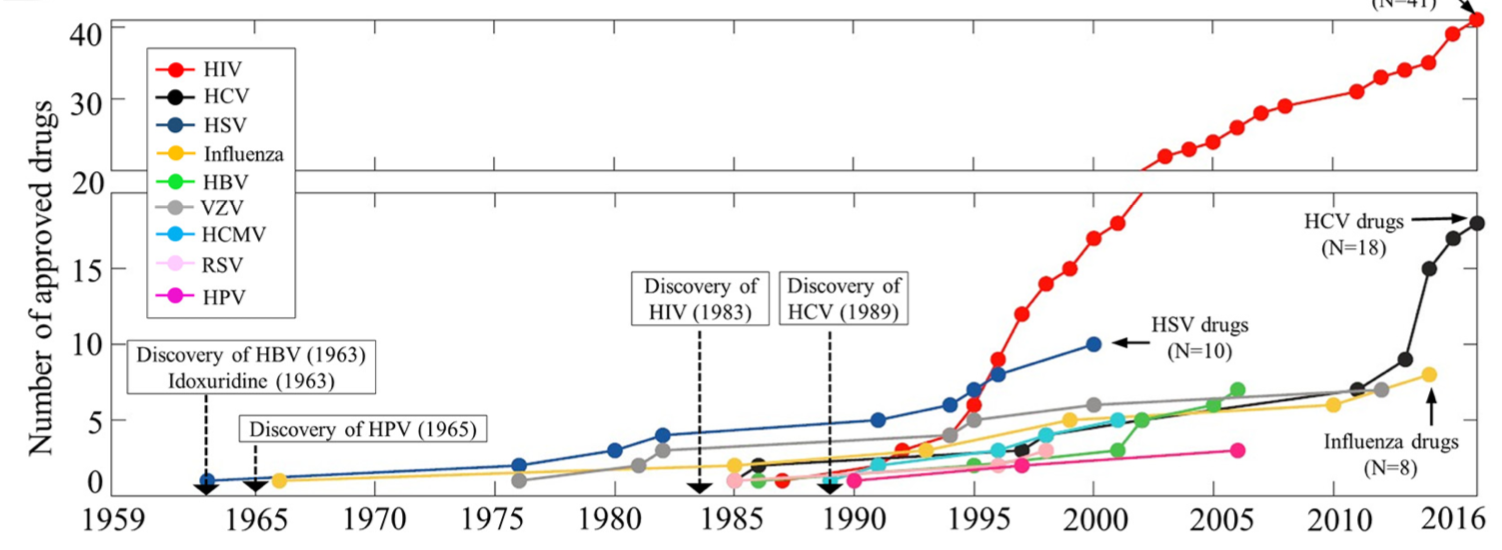

In [11]:
Image(filename='/kaggle/input/trialsdata/50years_antiviral_history.png', width=1200, height=800)

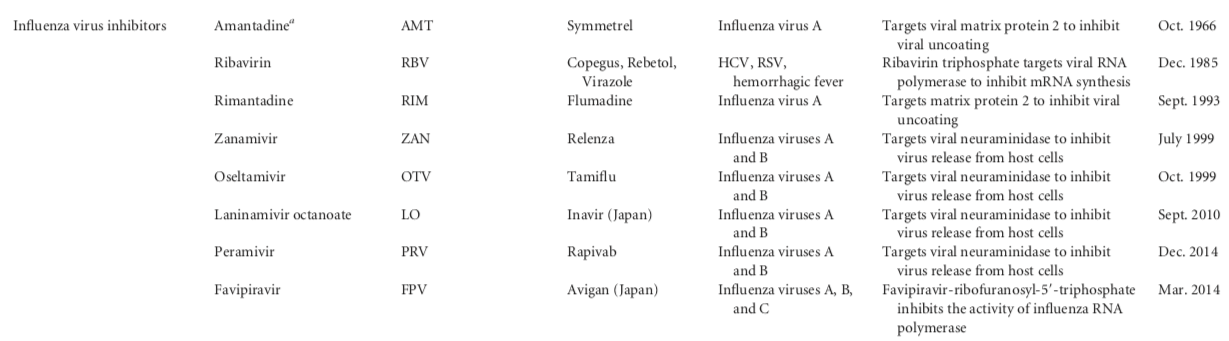

In [12]:
Image(filename='/kaggle/input/trialsdata/approveddrugs.png', width=1200, height=800)
# In particular, get data on approved flu drugs

There are only eight influenza drugs approved for use! Let's clean the data a bit and disambguiate trade names.

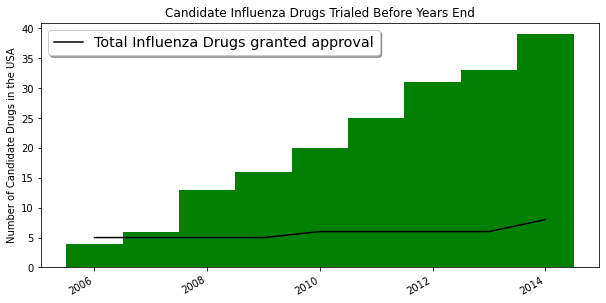

In [13]:
def extract_candidates(df):
    candidates  = [item.split('|') for item in df['Interventions'] if type(item) is str]
    cdrugs = [item.split(':')[1].lstrip() for subl in candidates for item in subl if item.split(':')[0] in 'Drug']
    # remove duplicates and nondrugs
    cdrugs = [item for item in cdrugs if not 'placebo' in item.lower()]
    cdrugs = [item.split()[np.argmax([len(iota) for iota in item.split()])] if 'mg' in item.lower() else item for item in cdrugs]
    cdrugs = [item.split(',')[0] for item in cdrugs]
    dupes = [('Symmetrel', 'Amantadine'), ('Copegus', 'Rebetol', 'Virazole', 'Ribavirin'), ('Flumadine', 'Rimantadine'), ('Relenza', 'Zanamivir'), ('(Tamiflu®)', '[Tamiflu]', 'Tamiflu', 'Oseltamivir'), ('Inavir', 'Laninamivir octanoate'), ('Rapivab', 'Peramivir'), ('Avigan', 'Favipiravir')]
    cdrugs = [generic[-1] if generic[-1] in item.split() else item for item in cdrugs for generic in dupes]
    cdrugs = ['Oseltamivir' if 'oseltamivir' in item.lower().split() else item for item in cdrugs ]    
    cdrugs = [drug for drug in cdrugs if 'vaccine' not in drug.lower()]
    cdrugs = list(set(cdrugs))
    return cdrugs

# grab candidates from clinicaltrials.gov read all csvs
rootfid = '/kaggle/input/trialsdata/'
yeardrug={}
for fid in os.listdir(rootfid):
    if fid[:3] in 'flu' and fid[-4:] in '.csv':
        yeardrug[fid.split('flu')[1][:4]] = pd.read_csv(rootfid+fid)

cdrugyear={}
for k,v in yeardrug.items():
    cdrugyear[k] = extract_candidates(v)

approved09 = ['Amantadine', 'Ribavirin', 'Rimantadine', 'Zanamivir', 'Oseltamivir']
approved09 = [drug.lower() for drug in approved09]
undisdrug09 = ['Laninamivir', 'Peramivir', 'Favipiravir', 'Baloxavir'] # Baloxavir approved in 2018, doesn't appear in the dataset
undisdrug09 = [drug.lower() for drug in undisdrug09]
undisdrug13 = undisdrug09[1:]
approved13 = approved09 + ['laninamivir']    
numcands = [len(cdrugyear[str(year)]) for year in range(2006,2015)]
approveddrugs = [5, 5, 5, 5, 6, 6, 6, 6, 8]

width = 1.0     # gives histogram aspect to the bar diagram 
plt.rcParams['figure.figsize'] = [10, 5]

fig, ax = plt.subplots()
ax.bar(range(2006,2015), numcands, width, color='g')
plt.ylabel('Number of Candidate Drugs in the USA')
plt.title('Candidate Influenza Drugs Trialed Before Years End')
ax.plot(range(2006,2015), approveddrugs, 'k-', label ='Total Influenza Drugs granted approval')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
fig.autofmt_xdate()
plt.show()

# Experimental architecture
As stated, a Roberta-large model for the masked language task on CORD-19 (pplx=2.4696) is used to calculate prediction scores on a query filtered by the target tokens to score relevance.  Using 'efficacy' as a target, prediction scores are calculated.

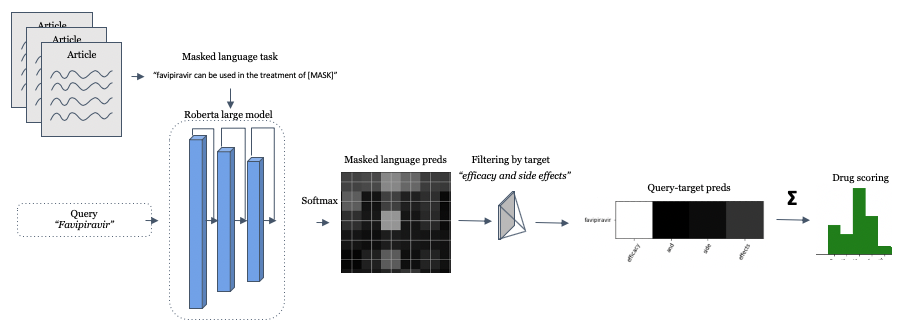

In [14]:
## Let's introduce our method, 
Image(filename='/kaggle/input/trialsdata/roberta_arch.png', width=1200, height=800)

The 44000 articles are used to train and test our model in an 80/20 split.

# Training the language model
Just use the run_language_modeling.py script in the pytorch transformers library: https://github.com/huggingface/transformers/blob/master/examples/run_language_modeling.py. Thanks for the hardwork from HuggingFace, AllenNLP, and Facebook!

We dust off our DGX-2 and run it at batch size 4 per GPU across 16 GPUs for 100k steps (~36 hours).

Why do we choose the masked language model task? The rationale is based off examining Fig. 2c from the "Latent Knowledge" paper, namely the MLM task is closest to the skip-gram training, which is predicting the target word given a context around the word. We take a leap of faith that training this on an appropriately large scale will give good results since the small models available publicly on generic data are hardly representive of our application.

In [15]:
# We work from the 3/20 release of the full text dataset with 44220 articles.
# Data prep is straightforward, change below path to /kaggle/input/ if running on competition machines. Glob doesn't seem to work quite right on competition machines.
from tqdm import tqdm
from glob import glob
dataroot = '/kaggle/input/CORD-19-research-challenge/'

def readjsonbody(fid):
    jjson = json.load(open(fid, 'r'))
    return [text['text'] for text in jjson['body_text']]

# read in json texts
passage = []
for fid in tqdm(glob(dataroot+'*/*/*.json')):
    try:
        passage += readjsonbody(fid)
    except:
        print('Whiffed on', fid)

# now write to a text line and 80% for train 20% for test, for language modeling task
random.seed(4)
random.shuffle(passage)

savefid = '/kaggle/working/covidpassages.txt'
with open(savefid, 'w') as f:
    for idx in tqdm(range(0,int(len(passage)*.8))):
        f.writelines(passage[idx]+'\n')
        
testfid = '/kaggle/working/testcovidpassages.txt'        
with open(testfid, 'w') as f:
    for idx in tqdm(range(int(len(passage)*.8), int(len(passage))) ):
        f.writelines(passage[idx]+'\n')

# Run the below on a good machine with at least 32GB per GPU
# !python /home/transformers/examples/run_language_modeling.py \
#     --output_dir=covidrobertamodel \
#     --model_type=roberta \
#     --model_name_or_path=roberta-large \
#     --do_train \
#     --train_data_file=/kaggle/working/covidpassages.txt \
#     --do_eval \
#     --eval_data_file=/kaggle/working/testcovidpassages.txt \
#     --mlm --save_steps 10000 --max_steps 100000 --per_gpu_train_batch_size 4
!cat /kaggle/input/covidrobertamodel/eval_results.txt

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


perplexity = tensor(2.4696)


We reach a pretty good perplexity of 2.4696, that's an effective branching factor of less than 3, the model really knows what's coming next.  In the original "Latent Knowledge" study, their dataset was approxmiately 600M words with heavy filtering and the full text CORD-19 corpus appears to fall in the same range and be of similar high quality. We earnestly thank the Allen Institute, CZR, MSR, Georgetown, White House, the NIH and all affilifates for their excellent dataset curation.

Now let's used this masked LM for predictions, as per the architecture figure above.

In [16]:
class roberta_score(nn.Module):
    def __init__(self, roberta_model = '/kaggle/input/covidrobertamodel/', dataset=None):
        super(roberta_score, self).__init__()        
        self.outmodel = RobertaForMaskedLM.from_pretrained(roberta_model)
        
    def forward(self, word_id, word_mask, target_id, target_mask):
        m = nn.Softmax(dim=2)
        output_embeds = self.outmodel(word_id, token_type_ids=None, attention_mask = word_mask)
        soft_embeds = m(output_embeds[0])        
        seqscore = torch.sum(soft_embeds.detach()[:,:,target_id], dim=2)        
        score = torch.sum(seqscore, dim=1)        
        score = score / (np.count_nonzero(target_id)*np.count_nonzero(word_id))        
        return score, seqscore

The prediction implementation is mostly on the forward pass.

# Attention visualization
Let's visualize some of the attentional weightings in our model and from our Query-Target method. We build on some visualization code from https://github.com/kexinhuang12345/clinicalBERT.

<Figure size 720x360 with 0 Axes>

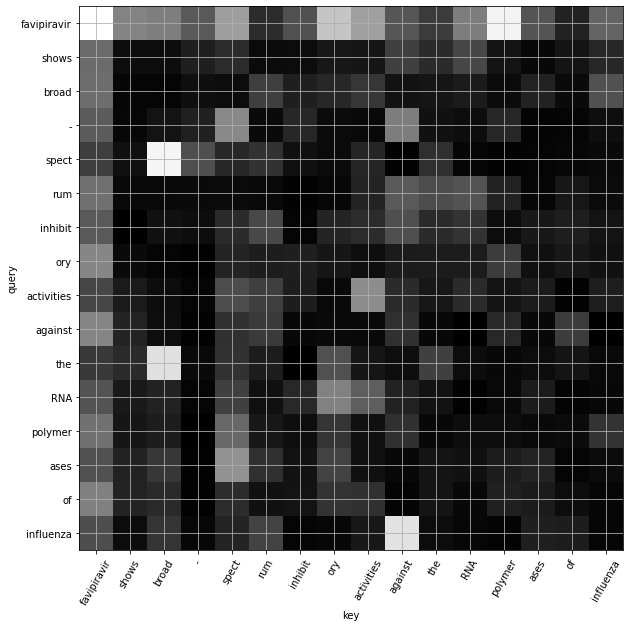

In [17]:
modeldir = '/kaggle/input/covidrobertamodel/'

config = modeling_roberta.RobertaConfig.from_json_file(modeldir+'config.json')
model = RobertaForMaskedLM(config)
tokenizer = RobertaTokenizer.from_pretrained(modeldir)
dicts=model.load_state_dict(torch.load(modeldir+"pytorch_model.bin",map_location ='cpu'))
def transpose_for_scores(config, x):
    new_x_shape = x.size()[:-1] + (config.num_attention_heads, int(config.hidden_size / config.num_attention_heads))
    x = x.view(*new_x_shape)
    return x.permute(0, 2, 1, 3)

def get_attention_scores(model,i,text):
    tokenized=tokenizer.tokenize(text)

    indexed_tokens=tokenizer.convert_tokens_to_ids(tokenized)

    segment_ids=[0]*len(indexed_tokens)
    t_tensor=torch.tensor([indexed_tokens])
    s_ids=torch.tensor([segment_ids])

    outputs_query= []
    outputs_key= []

    def hook_query(module, input, output):
        #print ('in query')
        outputs_query.append(output)

    def hook_key(module, input, output):
        #print ('in key')
        outputs_key.append(output)

    model.roberta.encoder.layer[i].attention.self.query.register_forward_hook(hook_query)
    model.roberta.encoder.layer[i].attention.self.key.register_forward_hook(hook_key)
    l=model(t_tensor,s_ids)
    
    query_layer = transpose_for_scores(config,outputs_query[0])
    key_layer = transpose_for_scores(config,outputs_key[0])
    
    attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
    attention_scores = attention_scores / math.sqrt(int(config.hidden_size / config.num_attention_heads))
    attention_probs = nn.Softmax(dim=-1)(attention_scores)
    
    return attention_probs,tokenized

text = 'favipiravir triphosphate shows broad-spectrum inhibitory activities against the RNA polymerases of influenza'
x,tokens=get_attention_scores(model.cpu(),-24,text) # second term is layer
map1=np.asarray(x[0][1].detach().numpy())
# reduction across favipiravir tokens
favrow = np.sum(map1[:10, :], axis =0)
favrow = np.expand_dims(favrow, axis=0)
map2 = np.concatenate((favrow, map1[10:,:]), axis=0)
favcol = np.sum(map2[:,:10], axis=1)
favcol = np.expand_dims(favcol, axis=1)
map3 = np.concatenate((favcol, map2[:,10:]),axis=1)
tok= ['favipiravir']+tokens[10:]
np.shape(map1[:10, :]), tokens[:10], np.shape(favrow), np.shape(map2), np.shape(map3), tok
# normalize
map3[:,0] = map3[:,0]/3.16
map3[0,:] = map3[0,:]/3.16

plt.clf()
f=plt.figure(figsize=(10,10))
ax = f.add_subplot(1,1,1)
i=ax.imshow(map3,interpolation='nearest',cmap='gray')
ax.set_yticks(range(len(tok)))
ax.set_yticklabels([token.replace('Ġ','') for token in tok])
ax.set_xticks(range(len(tok)))
ax.set_xticklabels([token.replace('Ġ','') for token in tok],rotation=60)
ax.set_xlabel('key')
ax.set_ylabel('query')
ax.grid(linewidth = 0.8)


def plot_attention(attmap, tokens):
    plt.clf()
    f=plt.figure(figsize=(10,10))
    ax = f.add_subplot(1,1,1)
    i=ax.imshow(attmap,interpolatlsion='nearest',cmap='gray')
    ax.set_yticks(range(len(tokens)))
    ax.set_yticklabels([token.replace('Ġ','') for token in tokens])
    ax.set_xticks(range(len(targettokens)))
    ax.set_xticklabels([token.replace('Ġ','') for token in targettokens], rotation=60)
    ax.set_xlabel('key')
    ax.set_ylabel('query')

Above we show the self-attention for a layer close to a word embedding for the input of "favipiravir triphosphate shows broad-spectrum inhibitory activities against the RNA polymerases of influenza". The model is learning some context-dependent associations. How about the query-target scoring?

# Query-target attention visualization

[Text(0, 0, 'efficacy'),
 Text(0, 0, 'and'),
 Text(0, 0, 'side'),
 Text(0, 0, 'effects')]

<Figure size 720x360 with 0 Axes>

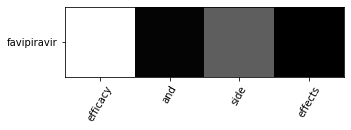

In [18]:
def get_query_target_scores(model,i, text, target):
    tokenized=tokenizer.tokenize(text)
    indexed_tokens=tokenizer.convert_tokens_to_ids(tokenized)    
    segment_ids=[0]*len(indexed_tokens)
    t_tensor=torch.tensor([indexed_tokens])
    s_ids=torch.tensor([segment_ids])

    targettokenized=tokenizer.tokenize(target)
    targetindexed_tokens=tokenizer.convert_tokens_to_ids(targettokenized)    
    targetsegment_ids=[0]*len(targetindexed_tokens)
    targett_tensor=torch.tensor([targetindexed_tokens])
    targets_ids=torch.tensor([targetsegment_ids])
        
    outputs_query= []
    outputs_key= []

    def hook_query(module, input, output):
        #print ('in query')
        outputs_query.append(output)

    def hook_key(module, input, output):
        #print ('in key')
        outputs_key.append(output)

    model.roberta.encoder.layer[i].attention.self.query.register_forward_hook(hook_query)
    model.roberta.encoder.layer[i].attention.self.key.register_forward_hook(hook_key)
    l=model(t_tensor,s_ids)
    
    query_layer = transpose_for_scores(config,outputs_query[0])
    key_layer = transpose_for_scores(config,outputs_key[0])

    t=model(targett_tensor, targets_ids)
    targetquery_layer = transpose_for_scores(config,outputs_query[0])
    targetkey_layer = transpose_for_scores(config,outputs_key[0])
    attention_scores = torch.matmul(query_layer, targetkey_layer[:,:,:len(targetindexed_tokens),:].transpose(-1, -2))
    attention_scores = attention_scores / math.sqrt(int(config.hidden_size / config.num_attention_heads))
    attention_probs = nn.Softmax(dim=-1)(attention_scores)
    
    return attention_probs, tokenized, targettokenized

text = 'favipiravir'
target = 'efficacy and side effects'
x, tokens, targettokens = get_query_target_scores(model.cpu(), -2, text, target)
map1=np.asarray(x[0][1].detach().numpy())
favrow = np.sum(map1[:10, :], axis =0)
favrow = np.expand_dims(favrow, axis=0)
map2 = np.concatenate((favrow, map1[10:,:]), axis=0)
favcol = np.sum(map2[:,1:], axis=1)
favcol = np.expand_dims(favcol, axis=1)
map3 = np.concatenate((favcol, map2[:,2:]),axis=1)
tok= ['favipiravir']+tokens[10:]

plt.clf()
f=plt.figure(figsize=(5,5))
ax = f.add_subplot(1,1,1)
i=ax.imshow(map3,interpolation='nearest',cmap='gray')
ax.set_yticks(range(len(tok)))
ax.set_yticklabels([token.replace('Ġ','') for token in tok])
ax.set_xticks(range(len(targettokens)-1))
targetlabels = ['efficacy']
targetlabels += targettokens[2:]
targetlabels = [token.replace('Ġ','') for token in targetlabels]
ax.set_xticklabels(targetlabels,rotation=60)

The above is showing that negative assocations can arise. Favipiravir is an approved antiviral drug which means it probably had to pass some initial assessments on side effects and efficacy.

# Extractive summarization

We can use the Query-Target method to highlight sections of the text. Here's a passage from the "50 Years" article.

Favipiravir (also known as T-705), 6-fluoro-3-hydroxy-2-pyrazine carboxamide, has been primarily pursued for the treatment of influenza infections (329–331). Approved in Japan, favipiravir can be used in the treatment of influenza A, B, and C virus infections (Table 2). According to the mechanism of drug action postulated by Furuta et al. (332), favipiravir is converted intracellularly to its ribofuranosyl monophosphate form by the phosphoribosyl transferase; two phosphorylations subsequently convert the ribofuranosyl monophosphate form to the triphosphate form, the active metabolite of favipiravir. Importantly, favipiravir triphosphate shows broad-spectrum inhibitory activities against the RNA polymerases of influenza A viruses (including the highly pathogenic H5N1 viruses) (330, 333) and many other positive-sense RNA and negative-sense RNA viruses (331). Recently, favipiravir has been proposed to treat patients infected with Ebola virus (EBOV) (334). Preliminary results suggest that favipiravir efficiently inhibits Ebola virus infections in mouse models (335, 336), but further investigations are still needed (337). In addition, favipiravir can inhibit the replication of human norovirus (325, 326) and human arenaviruses (Junin, Machupo, and Pichinde viruses) (338, 339), but these new applications require further evidence from clinical trials.

In [19]:
class roberta_passage_score(nn.Module):
    # Score a source phrase and target phrase for an analogy/prediction score
    def __init__(self, roberta_model = '/kaggle/input/covidrobertamodel', dataset=None):
        super(roberta_passage_score, self).__init__()        
        self.outmodel = RobertaForMaskedLM.from_pretrained(roberta_model)
        
    def forward(self, word_id, word_mask, target_id, target_mask):
        output_embeds = self.outmodel(word_id, token_type_ids=None, attention_mask = word_mask)
        # index by target word ids, selecting those probabilities for the sequences
        seqscore = torch.mean(output_embeds[0].detach()[:,:,target_id], dim=2)
        # average all sequence scores
        score = torch.mean(seqscore, dim=1)/np.sqrt(np.sum(word_mask.detach().cpu().numpy()))
        return score, seqscore
    
max_seq_length = 128
# testing analogy now
def convert_text_to_score_input(text):
    tokenized_text = tokenizer.tokenize(text)
    if len(tokenized_text) > max_seq_length:
        tokenized_text = tokenized_text[:max_seq_length]
    token_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
    padding = [0] * (max_seq_length - len(token_ids))
    token_ids += padding
    tokensid_tensor = torch.tensor(token_ids)

    idxes = torch.arange(0,max_seq_length,out=torch.LongTensor(max_seq_length)).unsqueeze(0)
    mask = Variable((idxes<len(tokenized_text)).float())
    return tokensid_tensor.unsqueeze(0), mask

def convert_target_to_score_input(text):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text))    

model = roberta_passage_score()    
text = 'Favipiravir (also known as T-705), 6-fluoro-3-hydroxy-2-pyrazine carboxamide, has been primarily pursued for the treatment of influenza infections (329–331). Approved in Japan, favipiravir can be used in the treatment of influenza A, B, and C virus infections (Table 2). According to the mechanism of drug action postulated by Furuta et al. (332), favipiravir is converted intracellularly to its ribofuranosyl monophosphate form by the phosphoribosyl transferase; two phosphorylations subsequently convert the ribofuranosyl monophosphate form to the triphosphate form, the active metabolite of favipiravir. Importantly, favipiravir triphosphate shows broad-spectrum inhibitory activities against the RNA polymerases of influenza A viruses (including the highly pathogenic H5N1 viruses) (330, 333) and many other positive-sense RNA and negative-sense RNA viruses (331). Recently, favipiravir has been proposed to treat patients infected with Ebola virus (EBOV) (334). Preliminary results suggest that favipiravir efficiently inhibits Ebola virus infections in mouse models (335, 336), but further investigations are still needed (337). In addition, favipiravir can inhibit the replication of human norovirus (325, 326) and human arenaviruses (Junin, Machupo, and Pichinde viruses) (338, 339), but these new applications require further evidence from clinical trials.'
targettext = 'efficacy'
targets = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(targettext))
targetinput, targetmask = convert_text_to_score_input(targettext)
scoreinput, mask = convert_text_to_score_input(text.split('.')[0])
score, seqscore = model(scoreinput, mask, targets, mask) # dont use targetinput, outputs an unreduced seq

textscores =[]
for sent in text.split('.'):
    scoreinput, mask = convert_text_to_score_input(sent)
    score, seqscore = model(scoreinput, mask, targets, mask)
    textscores.append(score)

print('High scores for:', text.split('.')[3:4], textscores[3:5])

# find start and end positions of entity to tag, slight clean the two highest phrases
detectionsb = ['favipiravir is converted intracellularly to its ribofuranosyl monophosphate form by the phosphoribosyl transferase; two phosphorylations subsequently convert the ribofuranosyl monophosphate form to the triphosphate form, the active metabolite of favipiravir', 'Importantly, favipiravir triphosphate shows broad-spectrum inhibitory activities against the RNA polymerases of influenza A viruses (including the highly pathogenic H5N1 viruses) (330, 333) and many other positive-sense RNA and negative-sense RNA viruses']
startends = []
for detection in detectionsb:
    start, end = text.find(detection), text.find(detection)+len(detection)
    startends.append((start,end))
startends    

# Write the entity dictionary
ents=[]
for idx in range(len(startends)):
    ent={}
    ent['start']=startends[idx][0]
    ent['end']=startends[idx][1]
    ent['label']='efficacy'
    ents.append(ent)

# Create a renderable dictionary
ex = [{"text": text,
       "ents": ents,
       "title": 'Favipiravir efficacy passage highlighting'}]
spacy.displacy.render(ex, style="ent", manual=True)

High scores for: [' (332), favipiravir is converted intracellularly to its ribofuranosyl monophosphate form by the phosphoribosyl transferase; two phosphorylations subsequently convert the ribofuranosyl monophosphate form to the triphosphate form, the active metabolite of favipiravir'] [tensor([2.3904]), tensor([2.3925])]


The Query-Target map is concise and adaptable to scoring.  

# Forward chaining analysis
Let's use these prediction scores to estimate which drugs will pass clinical trials.  In particular we'll perform a forward chaining analysis, where we limit the candidate drugs to the data available at that year. We test the target of "clinical trials efficacy". 

For the intellectual rigorous, we should train a new model for each year. Such experiments are underway – please search for the Arxiv submission soon!

In [31]:
target = 'clinical trials efficacy'
target = convert_target_to_score_input(target)

class roberta_score(nn.Module):
    def __init__(self, roberta_model = '/kaggle/input/covidrobertamodel', dataset=None):
        super(roberta_score, self).__init__()        
        self.outmodel = RobertaForMaskedLM.from_pretrained(roberta_model)
        
    def forward(self, word_id, word_mask, target_id, target_mask):
        m = nn.Softmax(dim=2)
        output_embeds = self.outmodel(word_id, token_type_ids=None, attention_mask = word_mask)
        soft_embeds = m(output_embeds[0])        
        seqscore = torch.sum(soft_embeds.detach()[:,:,target_id], dim=2)        
        score = torch.sum(seqscore, dim=1)        
        score = score / (np.count_nonzero(target_id)*np.count_nonzero(word_id))        
        return score, seqscore 
    
def return_undis_coverage_in_topN(cdrugs10, passdrugs10, N=5):
    scores10=[]
    dict10 = {}
    for text in cdrugs10:
        scoreinput, mask = convert_text_to_score_input(text)
        score, seqscore = model(scoreinput, mask, target, mask)

        scores10.append(score)
        dict10[text]=score
    sortscores10 = sorted(dict10.items(), key=lambda x: x[1])
    grades10top10 = [True if druguple[0].split()[0].lower() in passdrugs10 else False for druguple in sortscores10[-N:]]
    grades10 = [True if druguple[0].split()[0].lower() in passdrugs10 else False for druguple in sortscores10]
    top10acc, allacc = np.sum(grades10top10)/len(passdrugs10), np.sum(grades10)/len(grades10)
    return top10acc, allacc, sortscores10[-N:]   

# model = roberta_score()
approved09 = ['Amantadine', 'Ribavirin', 'Rimantadine', 'Zanamivir', 'Oseltamivir']
approved09 = [drug.lower() for drug in approved09]
undisdrug09 = ['Laninamivir', 'Peramivir', 'Favipiravir', 'Baloxavir']
undisdrug09 = [drug.lower() for drug in undisdrug09]
undisdrug13 = undisdrug09[1:]
approved13 = approved09 + ['laninamivir']
undisdrug16 = undisdrug09[-1] # balovir approved in 2018
approved16 = approved09+undisdrug09[:-1]
approved19 = approved09+undisdrug09

coverage={}
# build histogram with top N coverage while also filtering by even feasible
year=2006
N=30
while year<2010:        
    candidates = cdrugyear[str(year)]
    candidates = [drug.lower() for drug in candidates]
    # only assume coverage where even possible, ie. trials exist
    validundis = [drug for drug in undisdrug09 if drug in candidates]
    candidates = [drug for drug in candidates if drug not in approved09]
    coverage[(year)] = return_undis_coverage_in_topN(candidates, validundis, N=N)
    year+=1
while year<2014 and year>=2010:
    candidates = cdrugyear[str(year)]
    candidates = [drug.lower() for drug in candidates]    
    validundis = [drug for drug in undisdrug13 if drug in candidates]
    candidates = [drug  for drug in candidates if drug not in approved13]
    coverage[(year)] = return_undis_coverage_in_topN(candidates, validundis, N=N) 
    year+=1    
for year in range(2006,2014):
    print(coverage[(year)][2])
druglift = [yeardat[0]/yeardat[1] for yeardat in coverage.values()]

[('interleukin-2', tensor([8.0712e-06])), ('aluminum hydroxide', tensor([2.8451e-05])), ('peramivir', tensor([4.5415e-05])), ('mf59 adjuvant', tensor([5.9211e-05]))]
[('interleukin-2', tensor([8.0712e-06])), ('probenecid', tensor([2.5202e-05])), ('aluminum hydroxide', tensor([2.8451e-05])), ('peramivir', tensor([4.5415e-05])), ('mf59 adjuvant', tensor([5.9211e-05]))]
[('ceftriaxone', tensor([3.9189e-06])), ('interleukin-2', tensor([8.0712e-06])), ('iv ceftriaxone', tensor([2.0581e-05])), ('vt-122 high dose', tensor([2.2591e-05])), ('probenecid', tensor([2.5202e-05])), ('aluminum hydroxide', tensor([2.8451e-05])), ('vt-122 low dose', tensor([3.3770e-05])), ('peramivir', tensor([4.5415e-05])), ('mf59 adjuvant', tensor([5.9211e-05])), ('das181', tensor([7.1813e-05])), ('ceftaroline fosamil for injection', tensor([9.1769e-05])), ('clarithromycin', tensor([0.0001]))]
[('ceftriaxone', tensor([3.9189e-06])), ('interleukin-2', tensor([8.0712e-06])), ('iv ceftriaxone', tensor([2.0581e-05])), ('

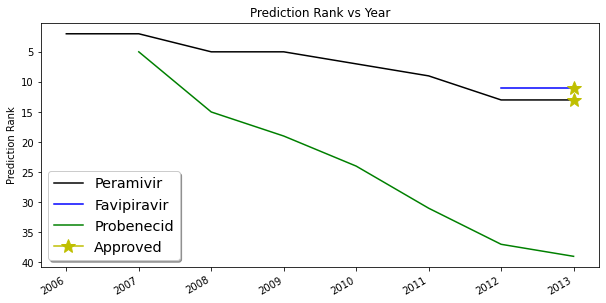

([99, 5, 15, 19, 24, 31, 37, 39],
 [2, 2, 5, 5, 7, 9, 13, 13],
 [99, 99, 99, 99, 99, 99, 11, 11])

In [33]:
# prediction rank of probenecid, peramivir, favipiravir
cumulrank, fcrank, pcrank =[], [],[]
for year in range(2006,2014):
    probrank = [idx for idx, drugpair in enumerate(coverage[(year)][2]) if drugpair[0] == 'probenecid']
    if probrank != []:
        truerank = len(coverage[(year)][2]) - probrank[0] if probrank[0] > len(coverage[(year)][2])//2-1 else probrank[0]+len(coverage[(year)][2])-1
        cumulrank.append(truerank)
    else:
        cumulrank.append(99)
        
    favirank = [idx for idx, drugpair in enumerate(coverage[(year)][2]) if drugpair[0] == 'favipiravir']
    if favirank != []:
        truerank = len(coverage[(year)][2])-favirank[0] if favirank[0]> len(coverage[(year)][2])//2-1 else favirank[0]+len(coverage[(year)][2])-1
        fcrank.append(truerank)
    else:
        fcrank.append(99)
    
    perarank = [idx for idx, drugpair in enumerate(coverage[(year)][2]) if drugpair[0] == 'peramivir']
    if perarank != []:
        truerank = len(coverage[(year)][2])-perarank[0] if perarank[0] > len(coverage[(year)][2])//2-1 else perarank[0]+len(coverage[(year)][2])        
        pcrank.append(truerank)
    else:
        pcrank.append(99)
    
cumulrank, fcrank, pcrank
    
width = 1.0     # gives histogram aspect to the bar diagram 
plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()
plt.ylabel('Prediction Rank')
plt.title('Prediction Rank vs Year')
ax.plot(range(2006,2014), pcrank, 'k-', label ='Peramivir')
ax.plot(range(2012,2014), fcrank[-2:], 'b-', label ='Favipiravir')
ax.plot(range(2007,2014), cumulrank[1:], 'g-', label ='Probenecid')
ax.plot([2013], [11], marker='*', markersize=15, color="y")
ax.plot([2013], [13], marker='*', markersize=15, color="y", label='Approved')

legend = ax.legend(loc='best', shadow=True, fontsize='x-large')
plt.gca().invert_yaxis()

fig.autofmt_xdate()
plt.show()
cumulrank, pcrank, fcrank

Now let's make our COVID-19 predictions now that we have some understanding of the Query-Target method.  We specifically test the target of "COVID-19 efficacy".

In [22]:
# Define drugs and task targets
drugs = ['Losartan', 'Hydroxychloroquine', 'Remdesivir', 'CD24Fc', 'Nitric Oxide Gas', 'Aviptadil', 'Sarilumab', 'PUL-042 Inhalation Solution', 'Favipiravir']
targets = ['COVID-19 efficacy']
combo2 = list(itertools.combinations(drugs, 2)) 
combo3 = list(itertools.combinations(drugs, 3)) 

def return_combocat(combo):
    concats=[]
    for grams in combo:
           concats.append( (''.join([w+' ' for w in grams])).strip())
    return concats   

drugcombo2 = return_combocat(combo2)
drugcombo3 = return_combocat(combo3)
len(drugs), len(targets), len(combo2), len(combo3), len(drugcombo2), len(drugcombo3)

(9, 1, 36, 84, 36, 84)

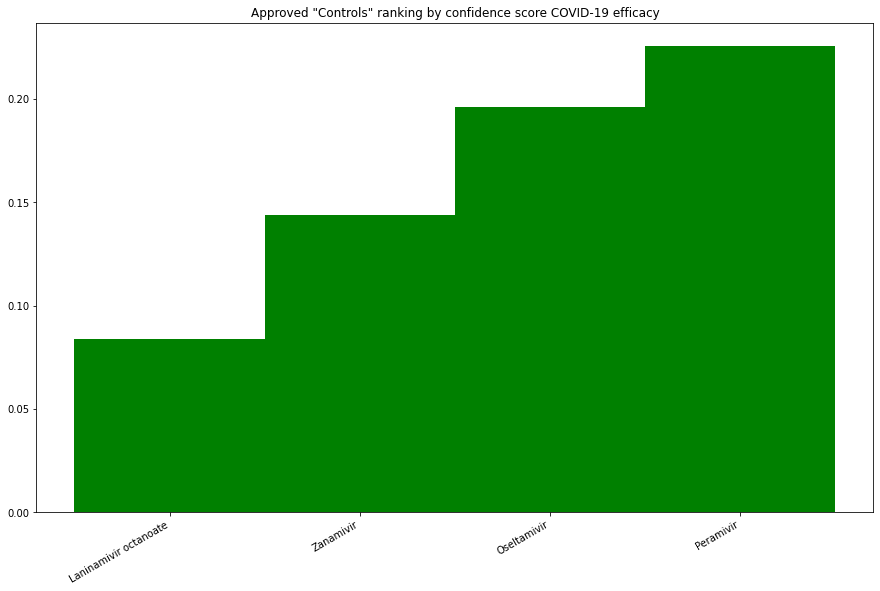

In [23]:
# control drugs
class roberta_score(nn.Module):
    def __init__(self, roberta_model = '/kaggle/input/covidrobertamodel/', dataset=None):
        super(roberta_score, self).__init__()        
        self.outmodel = RobertaForMaskedLM.from_pretrained(roberta_model)
        
    def forward(self, word_id, word_mask, target_id, target_mask):
        m = nn.Softmax(dim=2)
        output_embeds = self.outmodel(word_id, token_type_ids=None, attention_mask = word_mask)
        soft_embeds = m(output_embeds[0])        
        seqscore = torch.sum(soft_embeds.detach()[:,:,target_id], dim=2)        
        score = torch.sum(seqscore, dim=1)        
        score = score / (np.count_nonzero(target_id)*np.count_nonzero(word_id))        
        return score, seqscore        
    
model = roberta_score()
controldrugs = ['Zanamivir', 'Oseltamivir', 'Peramivir', 'Laninamivir octanoate']
targets = ['COVID-19 efficacy']

# Simple prediction from drugs and targeted effect
controlresults={}
for drug in controldrugs:
    for targ in targets:
        text, target = drug, targ
        scoreinput, mask = convert_text_to_score_input(text)
        target = convert_target_to_score_input(target)
        score, seqscore = model(scoreinput, mask, target, mask)
        controlresults[drug] = score
        
width = 1.0     # gives histogram aspect to the bar diagram 
plt.rcParams['figure.figsize'] = [15, 10]
fig, ax = plt.subplots()
scontrolresults = sorted((value, key) for (key,value) in controlresults.items())
ax.bar([val[1] for val in scontrolresults], [val[0] for val in scontrolresults], width, color='g')

plt.title('Approved "Controls" ranking by confidence score COVID-19 efficacy')
fig.autofmt_xdate()
plt.show()

Oseltamivir (Tamiflu) is a common flu drug, but it's known to be not too specific a target for COVID-19 (https://www.uchicagomedicine.org/forefront/prevention-and-screening-articles/wuhan-coronavirus).

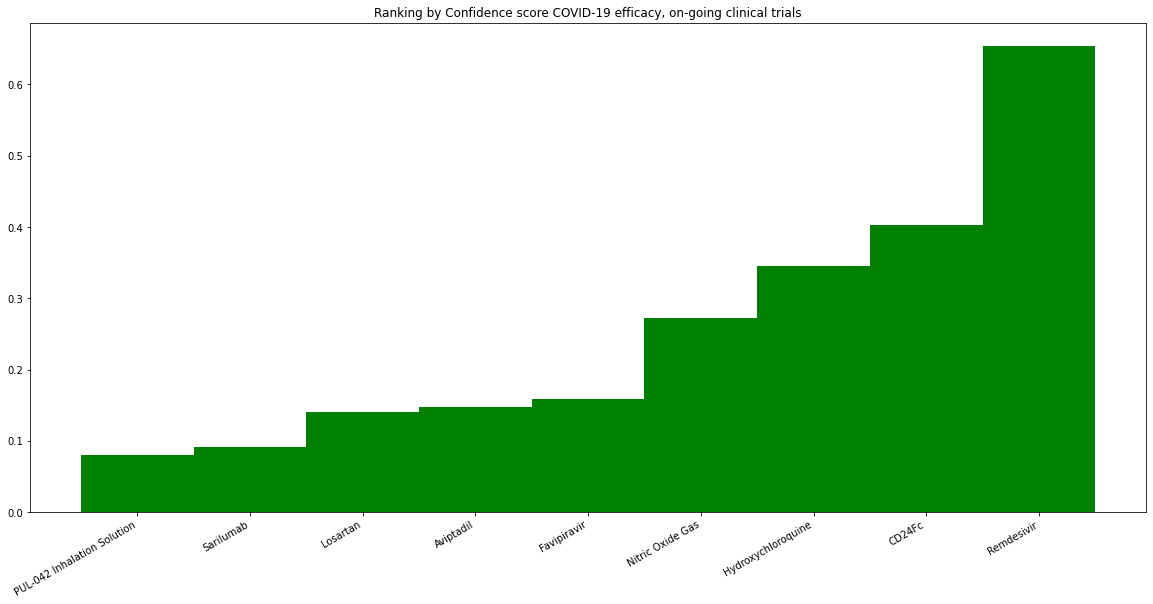

In [24]:
# Simple prediction from drugs and targeted effect
drugresults={}
effectresults={}
comboresults={}
for drug in drugs:
    for targ in targets:
        text, target = drug, targ
        scoreinput, mask = convert_text_to_score_input(text)
        target = convert_target_to_score_input(target)
        score, seqscore = model(scoreinput, mask, target, mask)
        comboresults[drug] = score        

width = 1.0     # gives histogram aspect to the bar diagram 
plt.rcParams['figure.figsize'] = [20, 10]

fig, ax = plt.subplots()
scomboresults = sorted((value, key) for (key,value) in comboresults.items())
ax.bar([val[1] for val in scomboresults], [val[0] for val in scomboresults], width, color='g')

plt.title('Ranking by Confidence score COVID-19 efficacy, on-going clinical trials')
fig.autofmt_xdate()
plt.show()

# Drug discovery
The power of knowledge discovery methods is considering drugs that have not even been surfaced.  We can make predictions on all combinations of clinical drugs in a fairly straightforward fashion by changing the input tokens.

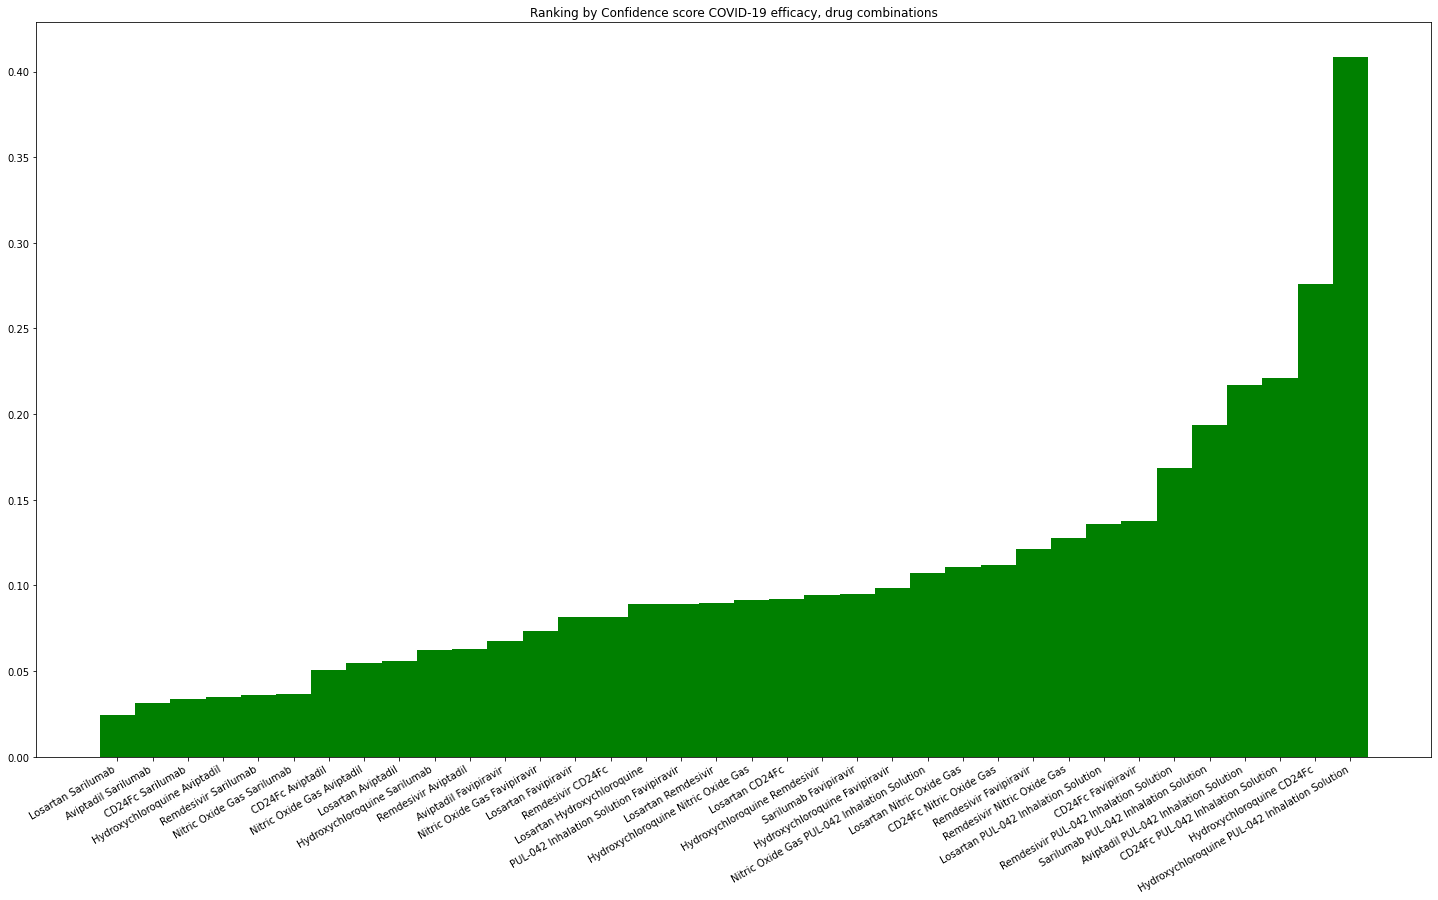

In [25]:
# Simple prediction from drugs and targeted effect
comboresults={}
for drug in drugcombo2:
    for targ in targets:
        text, target = drug, targ
        scoreinput, mask = convert_text_to_score_input(text)
        target = convert_target_to_score_input(target)
        score, seqscore = model(scoreinput, mask, target, mask)
        comboresults[drug] = score
        
width = 1.0     # gives histogram aspect to the bar diagram 
plt.rcParams['figure.figsize'] = [25, 15]
fig, ax = plt.subplots()
scomboresults = sorted((value, key) for (key,value) in comboresults.items())
ax.bar([val[1] for val in scomboresults], [val[0] for val in scomboresults], width, color='g')

plt.title('Ranking by Confidence score COVID-19 efficacy, drug combinations')
fig.autofmt_xdate()
plt.show()

We can examine if we change the target to side effects.

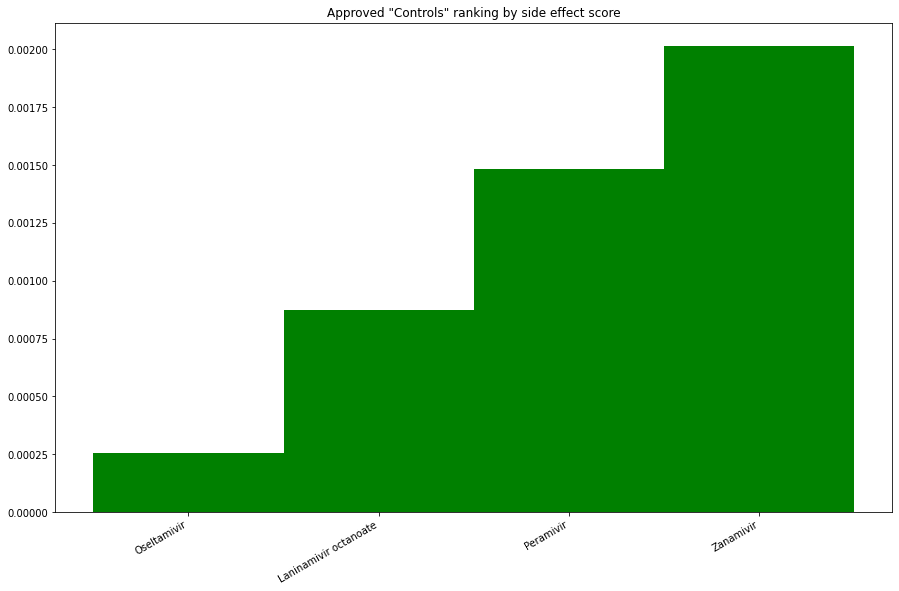

In [26]:
targets = ['side effects']
controlresults={}
for drug in controldrugs:
    for targ in targets:
        text, target = drug, targ
        scoreinput, mask = convert_text_to_score_input(text)
        target = convert_target_to_score_input(target)
        score, seqscore = model(scoreinput, mask, target, mask)
        controlresults[drug] = score
        
width = 1.0     # gives histogram aspect to the bar diagram 
plt.rcParams['figure.figsize'] = [15, 10]
fig, ax = plt.subplots()
scontrolresults = sorted((value, key) for (key,value) in controlresults.items())
ax.bar([val[1] for val in scontrolresults], [val[0] for val in scontrolresults], width, color='g')

plt.title('Approved "Controls" ranking by side effect score')
fig.autofmt_xdate()
plt.show()

It's at least understood that Oseltamivir (Tamiflu) is well tolerated.

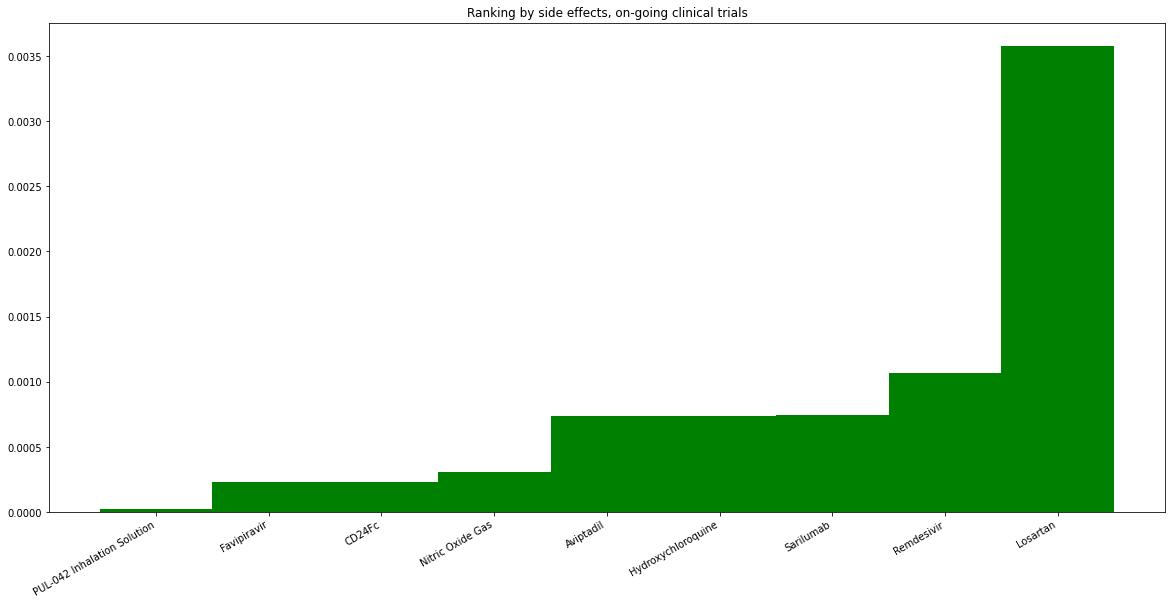

In [27]:
targets = ['side effects']
comboresults={}
for drug in drugs:
    for targ in targets:
        text, target = drug, targ
        scoreinput, mask = convert_text_to_score_input(text)
        target = convert_target_to_score_input(target)
        score, seqscore = model(scoreinput, mask, target, mask)
        comboresults[drug] = score        

width = 1.0     # gives histogram aspect to the bar diagram 
plt.rcParams['figure.figsize'] = [20, 10]

fig, ax = plt.subplots()
scomboresults = sorted((value, key) for (key,value) in comboresults.items())
ax.bar([val[1] for val in scomboresults], [val[0] for val in scomboresults], width, color='g')

plt.title('Ranking by side effects, on-going clinical trials')
fig.autofmt_xdate()
plt.show()

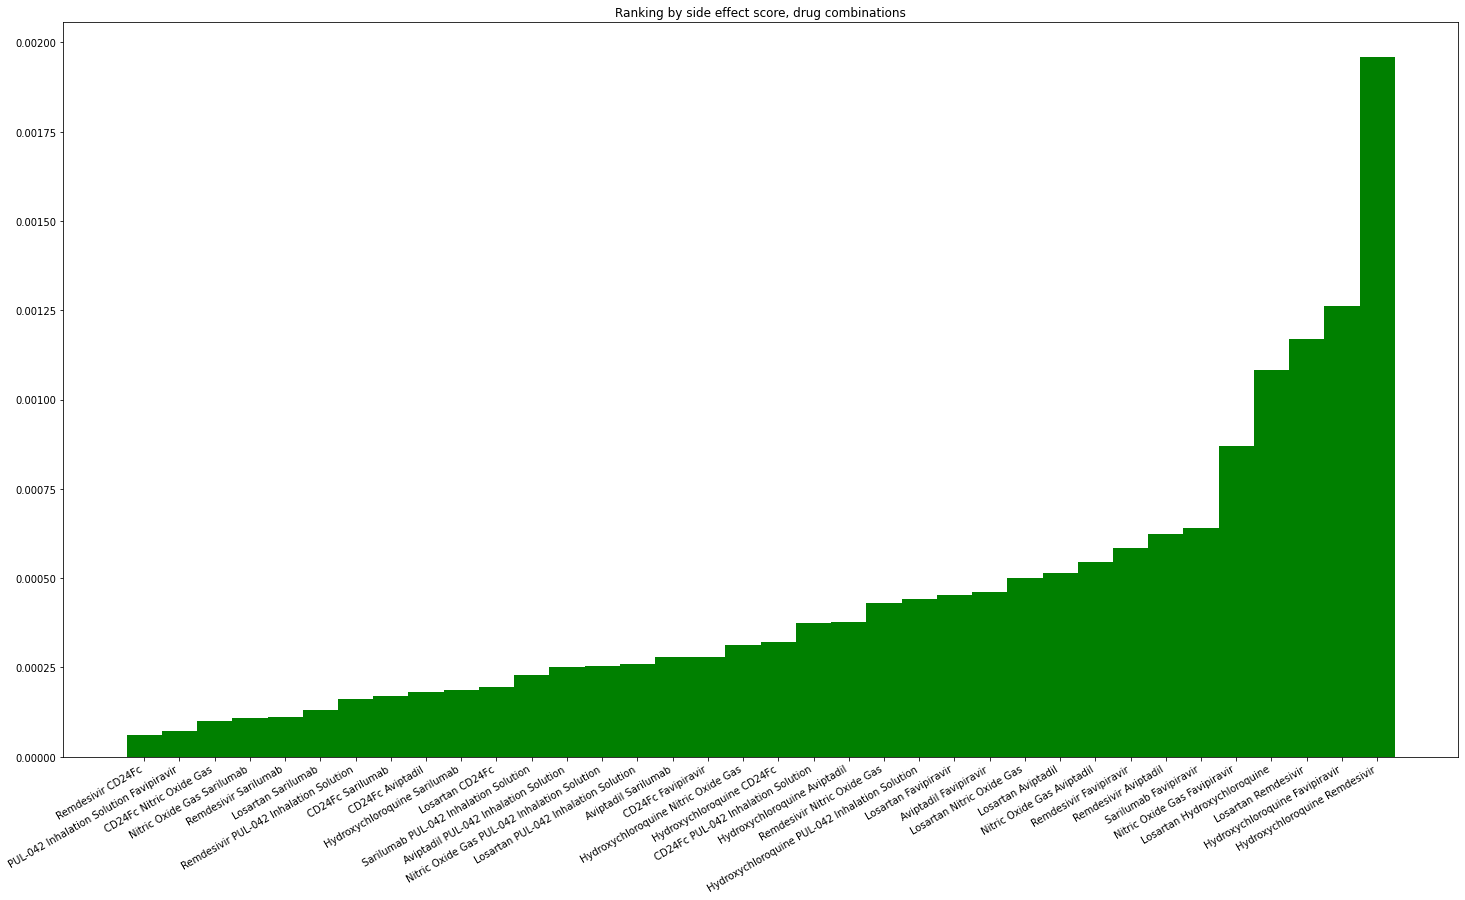

In [28]:
targets = ['side effects']
comboresults={}
for drug in drugcombo2:
    for targ in targets:
        text, target = drug, targ
        scoreinput, mask = convert_text_to_score_input(text)
        target = convert_target_to_score_input(target)
        score, seqscore = model(scoreinput, mask, target, mask)
        comboresults[drug] = score
        
width = 1.0     # gives histogram aspect to the bar diagram 
plt.rcParams['figure.figsize'] = [25, 15]
fig, ax = plt.subplots()
scomboresults = sorted((value, key) for (key,value) in comboresults.items())
ax.bar([val[1] for val in scomboresults], [val[0] for val in scomboresults], width, color='g')

plt.title('Ranking by side effect score, drug combinations')
fig.autofmt_xdate()
plt.show()                

We spare readers the eye chart of the triplet combinations.

# Concluding thoughts

We present a flexible transformer query-target for knowledge discovery that enables diverse applications such as extractive summarization given a specific target and prediction ranking for discovering drugs, in the vein of the "Latent Knowledge" approach.

In order to further boost confidence in the method, we need to verfiy against the original "Latent Knowledge" approach. Unfortunately, the data splits for the "Latent Knowledge" approach are not available (https://github.com/materialsintelligence/mat2vec/issues/22), but we have developed approximately 400 "drug analogies" similar to the "Latent Knowledge" materials analogies.  One of the weaknesses of the old (2013) skip-gram approach for domain specific applications is the massive vocabulary needed, 500k for the "Latent Knowledge" study and in our first training of word2vec on CORD-19, at least 400K vocabulary.  This appears to complicate the analogy task evaluation at the present moment, as simple lookup as per the original method can be expensive (essentially running inference for 500k examples for each test analogy if strictly apples to apples).  Another issue is overcoming the pretrain-finetune paradigm for analogies.  It really makes sense to finetune a model particularly for the analogy task as the vector space structure is not as straight-forward in deep transformer architectures as it is with word2vec, likely due to the pipeline across the entire layers (24 in the case of Roberta-large).  In any case, we have made in-roads on these issues and hope to release our results soon.

On the horizon, COVID-19 embedding visualization

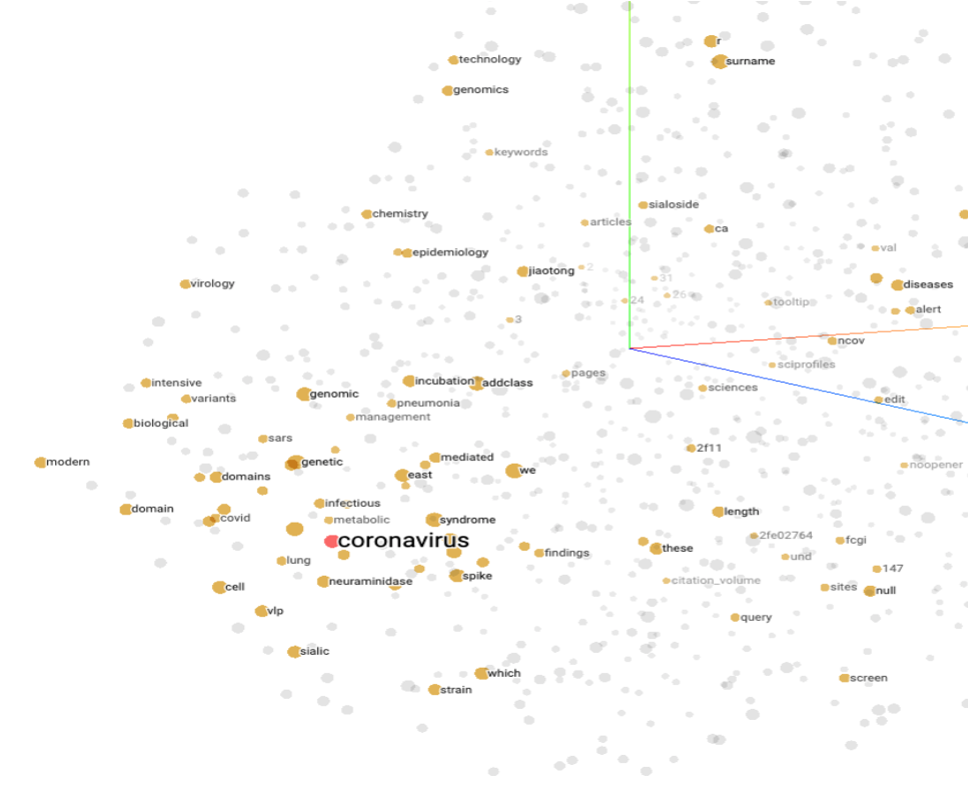

In [29]:
Image(filename='/kaggle/input/trialsdata/covid_embedding.png', width=800, height=800) 
